In [ ]:
import pandas as pd
import requests
import pandas_profiling
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
'''
idea principal: ver si en las zonas donde hay más terremotos hay más o menos densidad de población

el propio dataset nos da la información de la cantidad de terremotos

la densidad de población nos la dará una API

me gustaría llegar a representar el mapa de Turquía por colores según la cantidad de terremotos en las regiones

además, haré histogramas, el primero que se me ocurre es según la escala de richter, con bins
'''

In [16]:
res = requests.get('http://api.worldbank.org/v2/region?format=json')
apidata = res.json()

In [28]:
data.shape

(24007, 17)

In [17]:
data = pd.read_csv('earthquake.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24007 entries, 0 to 24006
Data columns (total 17 columns):
id           24007 non-null float64
date         24007 non-null object
time         24007 non-null object
lat          24007 non-null float64
long         24007 non-null float64
country      24007 non-null object
city         11754 non-null object
area         12977 non-null object
direction    10062 non-null object
dist         10062 non-null float64
depth        24007 non-null float64
xm           24007 non-null float64
md           24007 non-null float64
richter      24007 non-null float64
mw           5003 non-null float64
ms           24007 non-null float64
mb           24007 non-null float64
dtypes: float64(11), object(6)
memory usage: 3.1+ MB


In [18]:
data.describe()

,id,lat,long,dist,depth,xm,md,richter,mw,ms,mb
count,2.400700e+04,24007.000000,24007.000000,10062.000000,24007.000000,24007.000000,24007.000000,24007.000000,5003.000000,24007.000000,24007.000000
mean,1.991982e+13,37.929474,30.773229,3.175015,18.491773,4.056038,1.912346,2.196826,4.478973,0.677677,1.690561
std,2.060396e+11,2.205605,6.584596,4.715461,23.218553,0.574085,2.059780,2.081417,1.048085,1.675708,2.146108
min,1.910000e+13,29.740000,18.340000,0.100000,0.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.980000e+13,36.190000,26.195000,1.400000,5.000000,3.600000,0.000000,0.000000,4.100000,0.000000,0.000000
50%,2.000000e+13,38.200000,28.350000,2.300000,10.000000,3.900000,0.000000,3.500000,4.700000,0.000000,0.000000
75%,2.010000e+13,39.360000,33.855000,3.600000,22.400000,4.400000,3.800000,4.000000,5.000000,0.000000,4.100000
max,2.020000e+13,46.350000,48.000000,95.400000,225.000000,7.900000,7.400000,7.200000,7.700000,7.900000,7.100000


In [30]:
report = pandas_profiling.ProfileReport(data)
display(report)

Number of variables,17
Number of observations,24007
Total Missing (%),17.2%
Total size in memory,3.1 MiB
Average record size in memory,136.0 B
Numeric,11
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


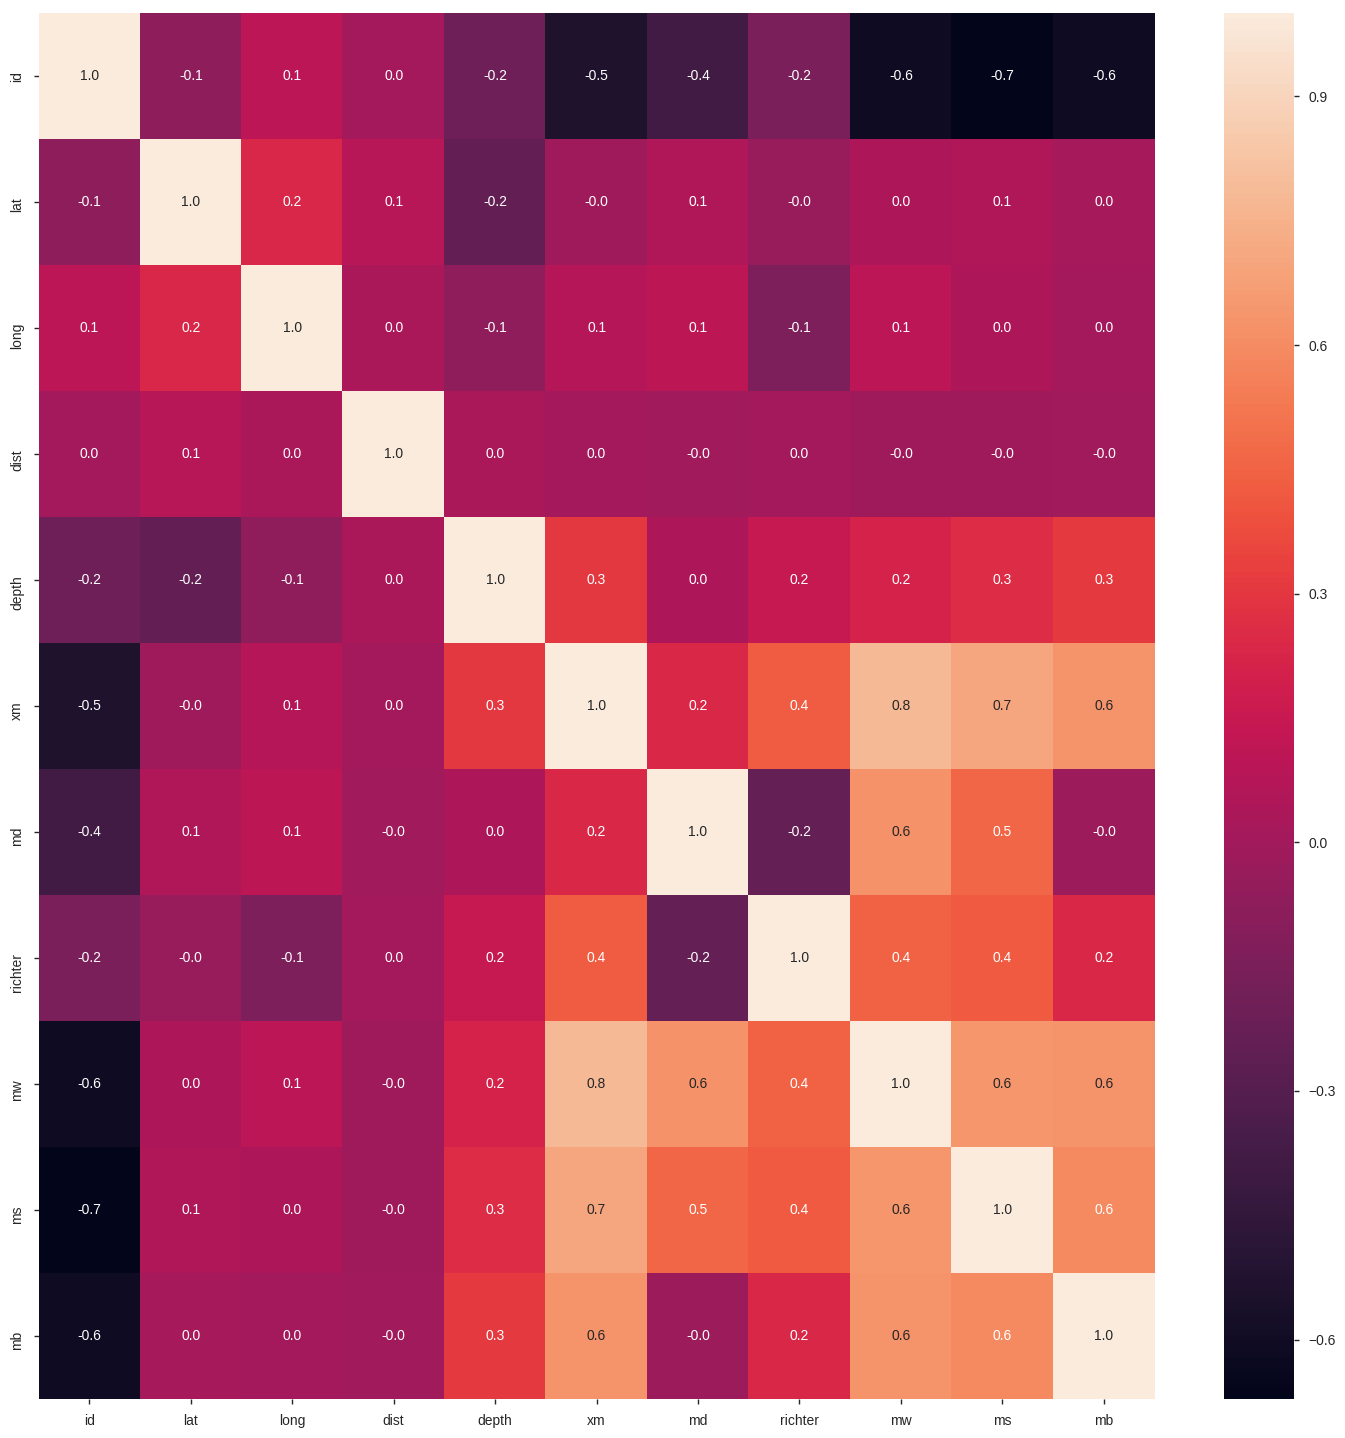

In [27]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, fmt= '.1f')
plt.show()